#### In this file we will be training on the data generated from the dummy_data_gen_with_added_bugs script and drawing inferences on the Cross Validation set.

In [5]:
%run "consolidate_logs.py"
%run "compute_similarity.py"

In [36]:
import pandas as pd
import numpy as np
import ast
import statistics
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import datetime
from consolidate_logs import consolidate_logs_in_time_window
from compute_similarity import get_similarity_scores

# =============================================================================
# Helper Functions
# =============================================================================

#Parse the Time_Window field which might either be a list or a single interval.
def parse_time_window(time_window_str):
    """
    Parses the Time_Window string into a list of (start, end) tuples.
    Expected formats:
      - "['2025-01-17 09:38:37 - 2025-01-17 11:10:29', ...]"
      - "2025-02-01 02:00:00 - 2025-02-01 06:00:00"
    """
    intervals = []
    try:
        # If the string looks like a list (begins with '['), use literal_eval
        if time_window_str.strip().startswith('['):
            windows = ast.literal_eval(time_window_str)
        else:
            windows = [time_window_str]
        # Each window should be of the form "start_time - end_time"
        for window in windows:
            parts = window.split(' - ')
            if len(parts) == 2:
                start_str, end_str = parts[0].strip(), parts[1].strip()
                start = pd.to_datetime(start_str)
                end = pd.to_datetime(end_str)
                intervals.append((start, end))
    except Exception as e:
        print("Error parsing time window:", e)
    return intervals
    
#     return features

def extract_features_from_logs(df_logs, jira_ticket_row):
    features = {}
    if df_logs is None or df_logs.empty:
        return features

    # Lowercase summary and description text for consistency.
    summary = jira_ticket_row["Summary"].lower()
    description = jira_ticket_row["Description"].lower()

    # Define keywords to filter on (case-insensitive)
    keywords = ["error", "failure", "outage", "failed"]

    # Fields we want to compare
    fields = {
        "event_name": "event_name",
        "log_message_as": "log_message",      # assuming default log_message is for analytics or AS logs
        "log_message_dd": "log_message_dd",
        "log_message_be": "log_message_be"
    }

    # Initialize dictionaries to accumulate scores
    sim_scores = {
        "summary": {field: {"cosine": 0.0, "wordwrap": 0.0, "levenshtein": 0.0} for field in fields},
        "description": {field: {"cosine": 0.0, "wordwrap": 0.0, "levenshtein": 0.0} for field in fields}
    }
    # Count number of rows used per field
    counts = {field: 0 for field in fields}

    # Helper: decide if a row should be processed, based on keywords.
    def row_matches(row):
        # Get lowercased strings from the row (safely)
        event = str(row.get("event_name", "")).lower()
        log_as = str(row.get("log_message", "")).lower()
        log_dd = str(row.get("log_message_dd", "")).lower()
        log_be = str(row.get("log_message_be", "")).lower()
        combined = f"{event} {log_as} {log_dd} {log_be}"
        return any(keyword in combined for keyword in keywords)

    # Process each log row
    for _, row in df_logs.iterrows():
        if not row_matches(row):
            continue

        counts_incremented = False
        for field_key, col_name in fields.items():
            text = str(row.get(col_name, "")).lower()
            # If there is no content to compare, skip.
            if not text:
                continue
            # Get similarity scores between the log field and both summary and description.
            sim_summary = get_similarity_scores(text, summary)
            sim_description = get_similarity_scores(text, description)
            sim_scores["summary"][field_key]["cosine"] += sim_summary.get('cosine_similarity_tfidf', 0.0)
            sim_scores["summary"][field_key]["wordwrap"] += sim_summary.get('word_overlap', 0.0)
            sim_scores["summary"][field_key]["levenshtein"] += sim_summary.get('levenshtein', 0.0)
            sim_scores["description"][field_key]["cosine"] += sim_description.get('cosine_similarity_tfidf', 0.0)
            sim_scores["description"][field_key]["wordwrap"] += sim_description.get('word_overlap', 0.0)
            sim_scores["description"][field_key]["levenshtein"] += sim_description.get('levenshtein', 0.0)
            counts[field_key] += 1
            counts_incremented = True
        # You can also add a flag or count that this row matched if needed.
    
    # Optionally, compute average scores (if count > 0)
    for text_type in sim_scores:  # "summary" and "description"
        for field_key in sim_scores[text_type]:
            cnt = counts[field_key]
            if cnt > 0:
                sim_scores[text_type][field_key]["cosine"] /= cnt
                sim_scores[text_type][field_key]["wordwrap"] /= cnt
                sim_scores[text_type][field_key]["levenshtein"] /= cnt

    # Add these features to the output dictionary. You can flatten the nested dictionary.
    for text_type in sim_scores:
        for field_key, metrics in sim_scores[text_type].items():
            for metric, value in metrics.items():
                feature_key = f"{text_type}_{field_key}_{metric}_score"
                features[feature_key] = value

    return features

def extract_static_features(row):
    """
    Extract static fields from the Jira ticket.
    You can customize which fields to include; here we add Project, Summary, and Description.
    """
    features = {}
    # features['Project'] = row.get("Project", "")
    features['Summary'] = row.get("Summary", "")
    features['Description'] = row.get("Description", "")
    # You can add more fields if needed.
    return features

# =============================================================================
# Training Phase
# =============================================================================

# Load your training data with the RCA labels.
df_training = pd.read_csv("jira_tickets_training.csv", parse_dates=["Created_Date"])

# Prepare lists to hold feature dictionaries and labels.
train_feature_dicts = []
train_labels = []

# For each training ticket, process its time windows to build features.
# For each Jira ticket, create a separate training example per time window.
for idx, row in df_training.iterrows():
    time_window_str = row['Time_Window']
    intervals = parse_time_window(time_window_str)
    # Extract static features that are common for all windows in this ticket.
    static_features = extract_static_features(row)
    label = row['RCA']
    
    # Create one training sample for each interval in the time window(s)
    for (start, end) in intervals:
        logs = consolidate_logs_in_time_window(start, end)
        log_features = extract_features_from_logs(logs, row)
        # Merge log-derived features with the static features from the ticket.
        combined_features = {**static_features, **log_features}
        train_feature_dicts.append(combined_features)
        train_labels.append(label)

# Vectorize the feature dictionaries.
dv = DictVectorizer(sparse=False)
X_train_features = dv.fit_transform(train_feature_dicts)

# Encode the RCA labels (assumes a limited set of unique RCAs).
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)

# For demonstration, split the training set for evaluation.
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_features, y_train_encoded, test_size=0.2, random_state=42
)

# Train a RandomForest/kNN classifier.
clf = KNeighborsClassifier(n_neighbors=4)
# clf = RandomForestClassifier(random_state=42)
clf.fit(X_tr, y_tr)
y_val_pred = clf.predict(X_val)
print("Classification Report on Training Data:")
unique_labels = np.unique(y_val)
print(classification_report(
    y_val, 
    y_val_pred, 
    labels=unique_labels, 
    target_names=le.inverse_transform(unique_labels)
))

# =============================================================================
# Prediction Phase for jira_tickets_cv.csv
# =============================================================================

# Load CV tickets.
df_cv = pd.read_csv("jira_tickets_cv.csv", parse_dates=["Created_Date"])
cv_feature_dicts = []
cv_issue_ids = []

for idx, row in df_cv.iterrows():
    time_window_str = row['Time_Window']
    intervals = parse_time_window(time_window_str)
    static_features = extract_static_features(row)
    # Create one training sample per time window for this issue.
    for (start, end) in intervals:
        logs = consolidate_logs_in_time_window(start, end)
        log_features = extract_features_from_logs(logs, row)
        combined_features = {**static_features, **log_features}
        cv_feature_dicts.append(combined_features)
        # Save issue id; if multiple windows per issue, you might later aggregate predictions.
        cv_issue_ids.append(row['Issue_ID'])
# Transform the feature dictionary to match training features.
X_cv_features = dv.transform(cv_feature_dicts)
cv_preds = clf.predict(X_cv_features)
pred_rcas = le.inverse_transform(cv_preds)

# Combine predictions with their corresponding Issue_ID.
df_cv_predictions = pd.DataFrame({
    "Issue_ID": cv_issue_ids,
    "Predicted_RCA": pred_rcas
})
print("Predictions for jira_tickets_cv:")
df_cv_predictions

Classification Report on Training Data:
                                                                               precision    recall  f1-score   support

                                                        Article vendor outage       1.00      1.00      1.00         8
            Audio Service not returning soundbytes. Probably TTS Service Down       1.00      1.00      1.00         8
Login vendor is throwing an error. Please check backend logs for more details       1.00      1.00      1.00         1
                           Video Service Overloaded. Possibly Peak Time Issue       1.00      1.00      1.00         4

                                                                     accuracy                           1.00        21
                                                                    macro avg       1.00      1.00      1.00        21
                                                                 weighted avg       1.00      1.00      1.00        21

Predi

,Issue_ID,Predicted_RCA
0,JIRA-CV-001,Article vendor outage
1,JIRA-CV-002,Video Service Overloaded. Possibly Peak Time I...
2,JIRA-CV-003,Login vendor is throwing an error. Please chec...
3,JIRA-CV-004,Audio Service not returning soundbytes. Probab...


In [27]:
n = 'LoginResultFailure'.lower()
keywords = ["error", "failure", "outage", "failed"]
as_log = 'LoginViewController: Login failed'.lower()
dd_log = 'LoginViewController: Login failed'.lower()
be_log = 'Login failure recorded from LoginViewController'.lower()

if (any(keyword in n for keyword in keywords)) or (any(keyword in f"{as_log} {dd_log} {be_log}" for keyword in keywords)):
    print("True")
else:
    print("False")

# event_name = 'LoginResultFailure'.lower()
# as_log = 'Login failure recorded: Login Failure message displayed'.lower()
# be_log = 'authentication error: Client SDK is deprecated, please upgrade to the version >= 6.7.8'.lower()
# dd_log = 'LoginActivity: User login using Google failed because of Server Error'.lower()
# similarity_scores = get_similarity_scores("Google Login Failure", be_log)


# event_name = 'VideoArticleError'.lower()
# as_log = 'VideoScreenError: Video Streaming Error impression recorded'.lower()
# be_log = 'Video streaming library overloaded; failed to serve video from {src} https://mynewsclips.stream/{article_id}'.lower()
# dd_log = 'VideoScreenError: Video Streaming Network Error from {src} for {article_id}'.lower()
# similarity_scores = get_similarity_scores("NFL Video Streaming Failure", be_log)
# similarity_scores
event_name = "ArticlesError".lower()
dd_msg = "AudioScreenError: Audio Streaming API throwing an error".lower()
as_msg = "AudioScreenError: Audio Error Screen impression recorded".lower()
be_msg = "AI Text-to-Speech service down; audio article failed https://mynewsaudiostream.stream/{article_id} has returned Internal Server Error (500) due to TTS service outage".lower()
a = get_similarity_scores("CNN Articles not loading", be_msg)
b = get_similarity_scores("CNN Articles not loading", as_msg)
c = get_similarity_scores("CNN Articles not loading", dd_msg)
d = get_similarity_scores("Users reported that CNN articles were not loading in this time window", be_msg)
e = get_similarity_scores("Users reported that CNN articles were not loading in this time window", as_msg)
f = get_similarity_scores("Users reported that CNN articles were not loading in this time window", dd_msg)
g = get_similarity_scores("CNN Articles not loading", event_name)
h = get_similarity_scores("Users reported that CNN articles were not loading in this time window", event_name)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)

print('\n')
event_name = "AudioArticlesError".lower()
a = get_similarity_scores("Wapo Audio Articles Error", be_msg)
b = get_similarity_scores("Wapo Audio Articles Error", as_msg)
c = get_similarity_scores("Wapo Audio Articles Error", dd_msg)
d = get_similarity_scores("Audio articles reported errors in this time window.", be_msg)
e = get_similarity_scores("Audio articles reported errors in this time window.", as_msg)
f = get_similarity_scores("Audio articles reported errors in this time window.", dd_msg)
g = get_similarity_scores("Wapo Audio Articles Error", event_name)
h = get_similarity_scores("Audio articles reported errors in this time window.", event_name)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)



True
{'cosine_similarity_tfidf': 0.0, 'word_overlap': 0.0, 'levenshtein': 0.1351351351351351}
{'cosine_similarity_tfidf': 0.0, 'word_overlap': 0.0, 'levenshtein': 0.19999999999999996}
{'cosine_similarity_tfidf': 0.0, 'word_overlap': 0.0, 'levenshtein': 0.20370370370370372}
{'cosine_similarity_tfidf': 0.0, 'word_overlap': 0.0, 'levenshtein': 0.25}
{'cosine_similarity_tfidf': 0.0, 'word_overlap': 0.0, 'levenshtein': 0.24637681159420288}
{'cosine_similarity_tfidf': 0.0, 'word_overlap': 0.0, 'levenshtein': 0.26086956521739135}


{'cosine_similarity_tfidf': 0.1337850929463124, 'word_overlap': 0.10526315789473684, 'levenshtein': 0.15540540540540537}
{'cosine_similarity_tfidf': 0.26055567105626243, 'word_overlap': 0.25, 'levenshtein': 0.2909090909090909}
{'cosine_similarity_tfidf': 0.23790309463326237, 'word_overlap': 0.2222222222222222, 'levenshtein': 0.31481481481481477}
{'cosine_similarity_tfidf': 0.04183711217318288, 'word_overlap': 0.041666666666666664, 'levenshtein': 0.22297297297297303

##### validate your training and inference 

Misclassified Samples:
Empty DataFrame
Columns: [Description=Audio articles reported errors in this time window., Description=Sessions using Twitter login encountered failures for a prolonged period., Description=Too many video streaming failure events in this time window, Description=Users reported that AP articles were not loading in this time window, Summary=AP Articles not loading, Summary=NFL Video Streaming Failure, Summary=NYT Audio Articles Error, Summary=Twitter Login Failure, description_as_log_cosine_score, description_as_log_levenshtein_score, description_as_log_wordwrap_score, description_be_log_cosine_score, description_be_log_levenshtein_score, description_be_log_wordwrap_score, description_dd_log_cosine_score, description_dd_log_levenshtein_score, description_dd_log_wordwrap_score, description_event_name_cosine_score, description_event_name_levenshtein_score, description_event_name_wordwrap_score, summary_as_log_cosine_score, summary_as_log_levenshtein_score, summary_as

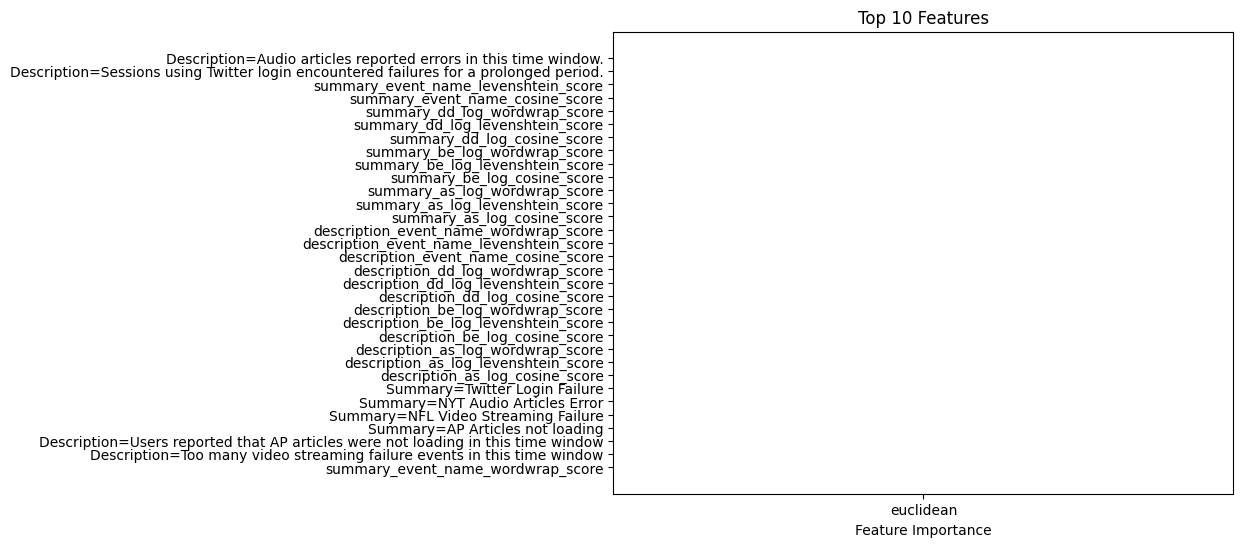

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Debugging: Compare Feature Vectors Between Correctly and Incorrectly Classified Samples --- #

# Suppose you have:
# - X_train_features: your feature matrix from the training phase (from DictVectorizer)
# - y_train_encoded: label-encoded true RCA values
# - clf: your trained RandomForest classifier
# - dv: your DictVectorizer object
# - le: your LabelEncoder object

# Get predictions on the training set.
def print_feature_vectors_importance():
    y_train_pred = clf.predict(X_train_features)

    # Create a DataFrame for easier comparison.
    feature_names = dv.get_feature_names_out()  # requires scikit-learn 1.0+
    df_features = pd.DataFrame(X_train_features, columns=feature_names)
    df_features['True_RCA'] = le.inverse_transform(y_train_encoded)
    df_features['Predicted_RCA'] = le.inverse_transform(y_train_pred)

    # Print samples where prediction was incorrect.
    misclassified = df_features[df_features['True_RCA'] != df_features['Predicted_RCA']]
    print("Misclassified Samples:")
    print(misclassified)

    # Optionally, if there is only one misclassification, examine it in detail:
    if misclassified.shape[0] == 1:
        print("Detailed view for the misclassified sample:")
        print(misclassified)  # Transposed view for easier comparison

    # --- Debugging: Feature Importance Analysis --- #

    importances = clf.effective_metric_
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    print("\nTop features by importance:")
    print(importance_df.head(10))

    # Plot the top 10 features to visually inspect which features are weighted highest.
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel("Feature Importance")
    plt.title("Top 10 Features")
    plt.gca().invert_yaxis()  # Invert so the highest importance is on top
    plt.show()

print_feature_vectors_importance()

In [ ]:
import requests

def predict_rca_with_ollama(summary, description, log_snippets):
    # Craft the prompt with few-shot examples or instructions as needed.
    prompt = f"""
    Below are details of a Jira ticket and selected log entries from the corresponding error time-window.
    Based on the provided information, please predict a concise Root Cause Analysis (RCA).

    Example 1:
    Summary: "Login failure due to invalid credentials"
    Description: "Multiple sessions indicate that users are unable to login because the authentication service is down."
    Logs: "ERROR: Authentication service not responding; Connection timed out."
    RCA: "Authentication service outage"

    Example 2:
    Summary: "Article loading error"
    Description: "Users report that articles are failing to load during peak traffic."
    Logs: "WARNING: Database timeout; slow response from content server."
    RCA: "Database/content server overload"

    Now, based on the following details, predict the RCA:
    Summary: {summary}
    Description: {description}
    Logs: {log_snippets}
    RCA:"""

    # Set up the request parameters. Adjust the model name, endpoint URL, and parameters based on your Ollama setup.
    data = {
        "prompt": prompt,
        "model": "your-local-model",  # For example, "llama2" or any model you've configured with Ollama.
        "max_tokens": 150,
        "temperature": 0.3
    }
    
    # The URL below is an example; use the actual endpoint provided by your Ollama instance.
    url = "http://localhost:11434/api/generate"
    
    response = requests.post(url, json=data)
    if response.status_code == 200:
        result = response.json()
        # Ensure that 'text' is the field that contains the generated output.
        return result.get("text", "").strip()
    else:
        return f"Error: {response.status_code} - {response.text}"

# Example usage:
if __name__ == "__main__":
    # Replace these with actual values extracted from your Jira ticket and logs.
    ticket_summary = "Article fails to load during vendor outage."
    ticket_description = "Multiple sessions indicate that the article consistently fails to load when the vendor service is unavailable."
    log_snippets = "Log1: ERROR: Vendor service timeout; Log2: FAILURE: Article retrieval failed."
    
    rca_prediction = predict_rca_with_ollama(ticket_summary, ticket_description, log_snippets)
    print("Predicted RCA:", rca_prediction)